# Case study of the Risk Assesment GmbH

In [1]:
import os
import pandas as pd

## Encoding problems

The following lines in the file **RAcredit_train.csv** contain encripted characters yielding encoding errors:
- 43240
- 44795
- 48316

To avoid these errors, we drop the column named **emp_title**.

In [2]:
def load_data(name, nrows):
    badnames = ['emp_title']
    goodcols = lambda x: x not in badnames
    df = pd.read_csv(name, usecols=goodcols, nrows=nrows, low_memory=False)
    return df

In [3]:
path = "/home/jose/Learning/cases"
df = load_data(os.path.join(path, "RAcredit_train.csv"), None)

In [4]:
df.shape

(77450, 135)

Before cleaning, the train dataset contains **77450** rows and **135** columns.

## Handle missing data

Drop rows with null *l_state*

In [5]:
df = df[df.l_state.notnull()]
df.shape

(76809, 135)

In [6]:
df.l_state.value_counts()

Fully Paid    74163
Default        2646
Name: l_state, dtype: int64

Drop columns with any missing value

In [7]:
df = df.dropna(axis=1, how='any')
df.shape

(76809, 53)

After cleaning, the train dataset contains **76809** rows and **53** columns.

## Analysis of categorical data

In [8]:
def cat_cols(df):
    return set(df.columns) - set(df._get_numeric_data().columns)

In [9]:
cat_cols(df)

{'addr_state',
 'earliest_cr_line',
 'grade',
 'home_ownership',
 'initial_list_status',
 'issue_d',
 'l_state',
 'pymnt_plan',
 'sub_grade',
 'term',
 'verification_status'}

Remove categorical data with more than 10 categories

In [10]:
for col in cat_cols(df):
    n = len(df[col].unique())
    if n>10:
        df.drop([col], axis=1, inplace=True)

In [11]:
cat_cols(df)

{'grade', 'l_state', 'term'}

Convert categorical variable into dummy variables

In [12]:
df = pd.get_dummies(df, columns=list(cat_cols(df)))

## Correlation analysis

Keep correlated variables with abs(corr)>0.1 

In [13]:
corr_matrix = df.corr()
corr_matrix = corr_matrix[abs(corr_matrix["l_state_Default"]) > 0.1]

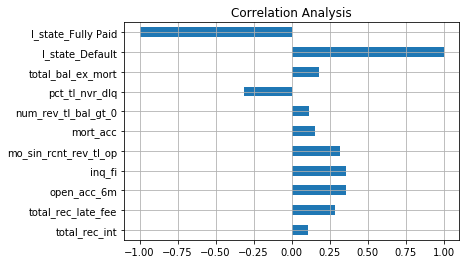

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

corr_matrix.l_state_Default.plot(kind='barh', grid=True, title="Correlation Analysis");

In [15]:
good_variables = corr_matrix.l_state_Default.index
df = df[good_variables]
df.drop(['l_state_Fully Paid'], axis=1, inplace=True)
df.shape

(76809, 10)

After the correlation analysis, only 10 columns remain in the dataframe.

## Classification models

In [16]:
from sklearn.preprocessing import StandardScaler

y = df.l_state_Default
df.drop(['l_state_Default'], axis=1, inplace=True)
X = StandardScaler().fit_transform(df)

In [17]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(max_depth=10, random_state=42);

from sklearn.neural_network import MLPClassifier
model2 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), random_state=42)

from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')

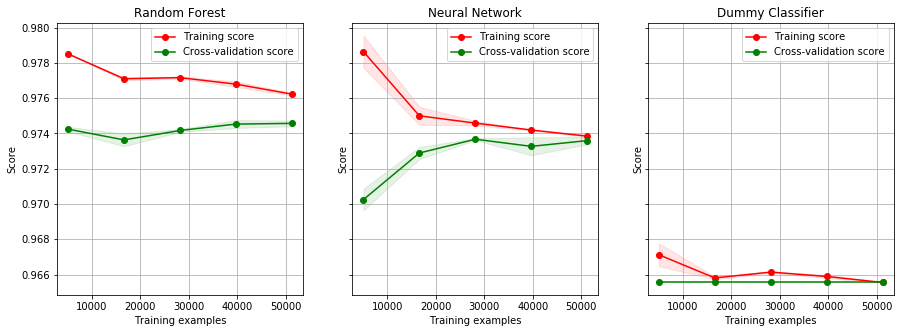

In [18]:
import scikitplot as skplt

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15,5))
skplt.estimators.plot_learning_curve(model1, X, y, ax=ax[0], title='Random Forest')
skplt.estimators.plot_learning_curve(model2, X, y, ax=ax[1], title='Neural Network')
skplt.estimators.plot_learning_curve(dummy, X, y, ax=ax[2], title='Dummy Classifier');

The model 1 displays higher score.

In [19]:
model1.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Model predictions

In [20]:
df = load_data(os.path.join(path, "RAcredit_test.csv"), None)
df.shape

(19213, 135)

In [21]:
df = df[good_variables.drop(['l_state_Default', 'l_state_Fully Paid'])]
df.shape

(19213, 9)

In [22]:
X = StandardScaler().fit_transform(df)
y_pred = model1.predict(X)

In [23]:
from collections import Counter

Counter(y_pred)

Counter({0: 18996, 1: 217})

The model predicts **217 defaults** in the test set.